In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE
import shap
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Labs/Team Project/dataset.csv')

print(data.head())
print(data.info())
print(data.describe())

   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   


In [ ]:
features = ["duration_ms", "explicit", "danceability", "energy", "key", "loudness",
            "mode", "speechiness", "acousticness", "instrumentalness", "liveness",
            "valence", "tempo", "time_signature"
]
target = "popularity"

X = data[features]
y = data[target]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True)
}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if name != "Linear Regression":
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average="weighted")
        rec = recall_score(y_test, y_pred, average="weighted")
        f1 = f1_score(y_test, y_pred, average="weighted")

        try:
            if hasattr(model, "predict_proba"):
                auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
            elif hasattr(model, "decision_function"):
                decision_scores = model.decision_function(X_test)
                auc = roc_auc_score(y_test, decision_scores, multi_class='ovr')
            else:
                auc = None
        except Exception as e:
            print(f"AUC could not be calculated for {name}: {e}")
            auc = None

        print(f"{name} - Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}, AUC: {auc:.2f}"
              if auc is not None else
              f"{name} - Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}, AUC: N/A")

    else:
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      mae = mean_absolute_error(y_test, y_pred)
      print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

Linear Regression - RMSE: 21.96, MAE: 18.34


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC could not be calculated for Decision Tree: Number of classes in y_true not equal to the number of columns in 'y_score'
Decision Tree - Accuracy: 0.33, Precision: 0.31, Recall: 0.33, F1: 0.32, AUC: N/A


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC could not be calculated for Random Forest: Number of classes in y_true not equal to the number of columns in 'y_score'
Random Forest - Accuracy: 0.35, Precision: 0.37, Recall: 0.35, F1: 0.33, AUC: N/A


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC could not be calculated for SVM: Number of classes in y_true not equal to the number of columns in 'y_score'
SVM - Accuracy: 0.15, Precision: 0.14, Recall: 0.15, F1: 0.05, AUC: N/A


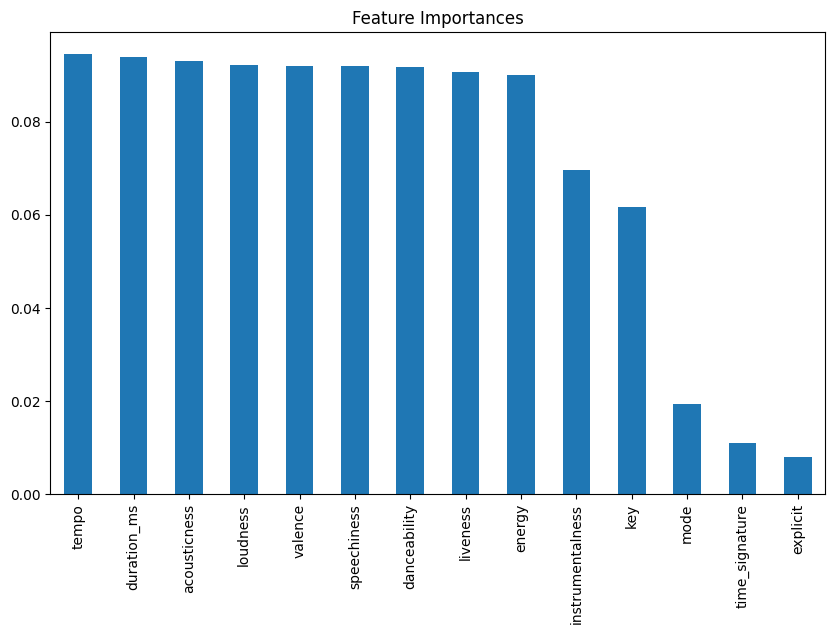

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=features)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,6))
plt.title('Feature Importances')
plt.show()

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features)

In [ ]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('rf', RandomForestClassifier()),
    ('dt', DecisionTreeClassifier()),
    ('svm', SVC(probability=True))
]
stack = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier())

stack.fit(X_train, y_train)
stack_pred = stack.predict(X_test)

acc = accuracy_score(y_test, stack_pred)
prec = precision_score(y_test, stack_pred, average="weighted")
rec = recall_score(y_test, stack_pred, average="weighted")
f1 = f1_score(y_test, stack_pred, average="weighted")
print(f"Stacking Ensemble - Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}")

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
cv_score = cross_val_score(best_rf, X_scaled, y, cv=10, scoring='accuracy')
print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.2f}")